# Phase 5B2: Seasonal Copula Analysis

**Objective**: Test if dependence structure varies by season

**Key Question from Phase 4B**: We found τ(Hs-Wind) = 0.45 averaged over all seasons. But:
- Are **winter storms more tightly coupled** (higher τ)?
- Are **summer conditions more independent** (lower τ)?
- Should we use **seasonal copulas** for better risk assessment?

**What We'll Test**:
1. Calculate **Kendall's τ** for each season (Winter, Spring, Summer, Autumn)
2. Fit **copula families** (Gaussian, Gumbel, Clayton, Frank) to each season
3. Test if **seasonal copulas improve joint probability estimates**
4. Calculate **seasonal dependence ratios**

**Expected Hypothesis**:
- ❄️ **Winter**: τ(Hs-Wind) > 0.50 (strong coupling during storms)
- ☀️ **Summer**: τ(Hs-Wind) < 0.35 (weaker coupling, calmer conditions)
- 🌊 **Current**: τ(Hs-Current) ≈ 0.09 for ALL seasons (tide-driven, season-agnostic)

**Data**: 10 years of ERA5 + CMEMS (2015-2025)

---

## PART 1: SETUP & DATA LOADING

In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kendalltau, pearsonr, spearmanr
from scipy.stats import norm, gaussian_kde
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("✅ Imports complete")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

✅ Imports complete
NumPy: 2.2.6
Pandas: 2.3.3


In [2]:
# Cell 2: Load data and Phase 4B/5B1 results

print("="*80)
print("LOADING DATA FOR SEASONAL COPULA ANALYSIS")
print("="*80)

# Load monthly maxima with augmented current data
df_monthly = pd.read_csv('../data/processed/phase4_mcmc/monthly_maxima_augmented.csv')
df_monthly['year_month'] = pd.to_datetime(df_monthly['year_month']).dt.to_period('M')
df_monthly['month'] = df_monthly['year_month'].dt.month

print(f"\nMonthly maxima shape: {df_monthly.shape}")
print(f"Date range: {df_monthly['year_month'].min()} to {df_monthly['year_month'].max()}")
print(f"Variables: {df_monthly.columns.tolist()}")

# Load Phase 4B copula parameters (averaged baseline)
with open('../data/processed/phase4b/copula_parameters.pkl', 'rb') as f:
    copula_4b = pickle.load(f)

print(f"\nPhase 4B Results (AVERAGED over all seasons):")
print(f"  τ(Hs-Wind): {copula_4b['hs_wind']['kendall_tau']:.3f}")
print(f"  τ(Hs-Current): {copula_4b['hs_current']['kendall_tau']:.3f}")
print(f"  Best copula (Hs-Wind): {copula_4b['hs_wind']['best_copula']}")
print(f"  Best copula (Hs-Current): {copula_4b['hs_current']['best_copula']}")

# Load Phase 5B1 seasonal EVA results
with open('../data/processed/phase5b1/seasonal_eva_results.pkl', 'rb') as f:
    eva_5b1 = pickle.load(f)

print(f"\n✅ Phase 5B1 seasonal EVA distributions loaded")

print("\n" + "="*80)
print("GOAL: Test if τ(Hs-Wind) and τ(Hs-Current) vary by season")
print("="*80)

LOADING DATA FOR SEASONAL COPULA ANALYSIS

Monthly maxima shape: (131, 9)
Date range: 2015-01 to 2025-11
Variables: ['year_month', 'hs', 'wind', 'current_mean', 'current_lower', 'current_upper', 'current_std', 'is_imputed', 'month']

Phase 4B Results (AVERAGED over all seasons):
  τ(Hs-Wind): 0.668
  τ(Hs-Current): 0.013
  Best copula (Hs-Wind): Gaussian
  Best copula (Hs-Current): Clayton

✅ Phase 5B1 seasonal EVA distributions loaded

GOAL: Test if τ(Hs-Wind) and τ(Hs-Current) vary by season


## PART 2: SEASONAL DATA SPLITTING & DEPENDENCE METRICS

In [3]:
# Cell 3: Split data by season and calculate Kendall's tau

# Define meteorological seasons
SEASONS = {
    'Winter': [12, 1, 2],   # DJF
    'Spring': [3, 4, 5],    # MAM
    'Summer': [6, 7, 8],    # JJA
    'Autumn': [9, 10, 11]   # SON
}

# Add season column
df_monthly['season'] = df_monthly['month'].apply(lambda m:
    'Winter' if m in SEASONS['Winter'] else
    'Spring' if m in SEASONS['Spring'] else
    'Summer' if m in SEASONS['Summer'] else
    'Autumn'
)

print("\n" + "="*80)
print("SEASONAL DEPENDENCE ANALYSIS")
print("="*80)

# Calculate Kendall's tau for each season
seasonal_dependence = {}

for season in SEASONS.keys():
    df_season = df_monthly[df_monthly['season'] == season]
    
    # Hs-Wind
    tau_hw, p_hw = kendalltau(df_season['hs'], df_season['wind'])
    rho_hw, _ = pearsonr(df_season['hs'], df_season['wind'])
    
    # Hs-Current
    tau_hc, p_hc = kendalltau(df_season['hs'], df_season['current_mean'])
    rho_hc, _ = pearsonr(df_season['hs'], df_season['current_mean'])
    
    seasonal_dependence[season] = {
        'n_months': len(df_season),
        'hs_wind': {
            'kendall_tau': tau_hw,
            'p_value': p_hw,
            'pearson_r': rho_hw
        },
        'hs_current': {
            'kendall_tau': tau_hc,
            'p_value': p_hc,
            'pearson_r': rho_hc
        }
    }
    
    print(f"\n{season} ({len(df_season)} months):")
    print(f"  Hs-Wind:    τ = {tau_hw:.3f} (p={p_hw:.4f}), ρ = {rho_hw:.3f}")
    print(f"  Hs-Current: τ = {tau_hc:.3f} (p={p_hc:.4f}), ρ = {rho_hc:.3f}")

# Compare to Phase 4B average
print("\n" + "-"*80)
print("Phase 4B (AVERAGED over all seasons):")
print(f"  Hs-Wind:    τ = {copula_4b['hs_wind']['kendall_tau']:.3f}")
print(f"  Hs-Current: τ = {copula_4b['hs_current']['kendall_tau']:.3f}")

# Calculate seasonal variation
tau_hw_seasonal = [seasonal_dependence[s]['hs_wind']['kendall_tau'] for s in SEASONS.keys()]
tau_hc_seasonal = [seasonal_dependence[s]['hs_current']['kendall_tau'] for s in SEASONS.keys()]

print("\n" + "-"*80)
print("SEASONAL VARIATION:")
print(f"  Hs-Wind τ:    range = {min(tau_hw_seasonal):.3f} to {max(tau_hw_seasonal):.3f}, Δ = {max(tau_hw_seasonal) - min(tau_hw_seasonal):.3f}")
print(f"  Hs-Current τ: range = {min(tau_hc_seasonal):.3f} to {max(tau_hc_seasonal):.3f}, Δ = {max(tau_hc_seasonal) - min(tau_hc_seasonal):.3f}")

print("\n✅ Seasonal dependence metrics calculated")


SEASONAL DEPENDENCE ANALYSIS

Winter (32 months):
  Hs-Wind:    τ = 0.262 (p=0.0357), ρ = 0.412
  Hs-Current: τ = -0.018 (p=0.8835), ρ = -0.062

Spring (33 months):
  Hs-Wind:    τ = 0.629 (p=0.0000), ρ = 0.776
  Hs-Current: τ = 0.242 (p=0.0489), ρ = 0.229

Summer (33 months):
  Hs-Wind:    τ = 0.568 (p=0.0000), ρ = 0.785
  Hs-Current: τ = -0.203 (p=0.1022), ρ = -0.097

Autumn (33 months):
  Hs-Wind:    τ = 0.648 (p=0.0000), ρ = 0.860
  Hs-Current: τ = -0.113 (p=0.3598), ρ = -0.338

--------------------------------------------------------------------------------
Phase 4B (AVERAGED over all seasons):
  Hs-Wind:    τ = 0.668
  Hs-Current: τ = 0.013

--------------------------------------------------------------------------------
SEASONAL VARIATION:
  Hs-Wind τ:    range = 0.262 to 0.648, Δ = 0.386
  Hs-Current τ: range = -0.203 to 0.242, Δ = 0.445

✅ Seasonal dependence metrics calculated


## PART 3: VISUALIZE SEASONAL DEPENDENCE

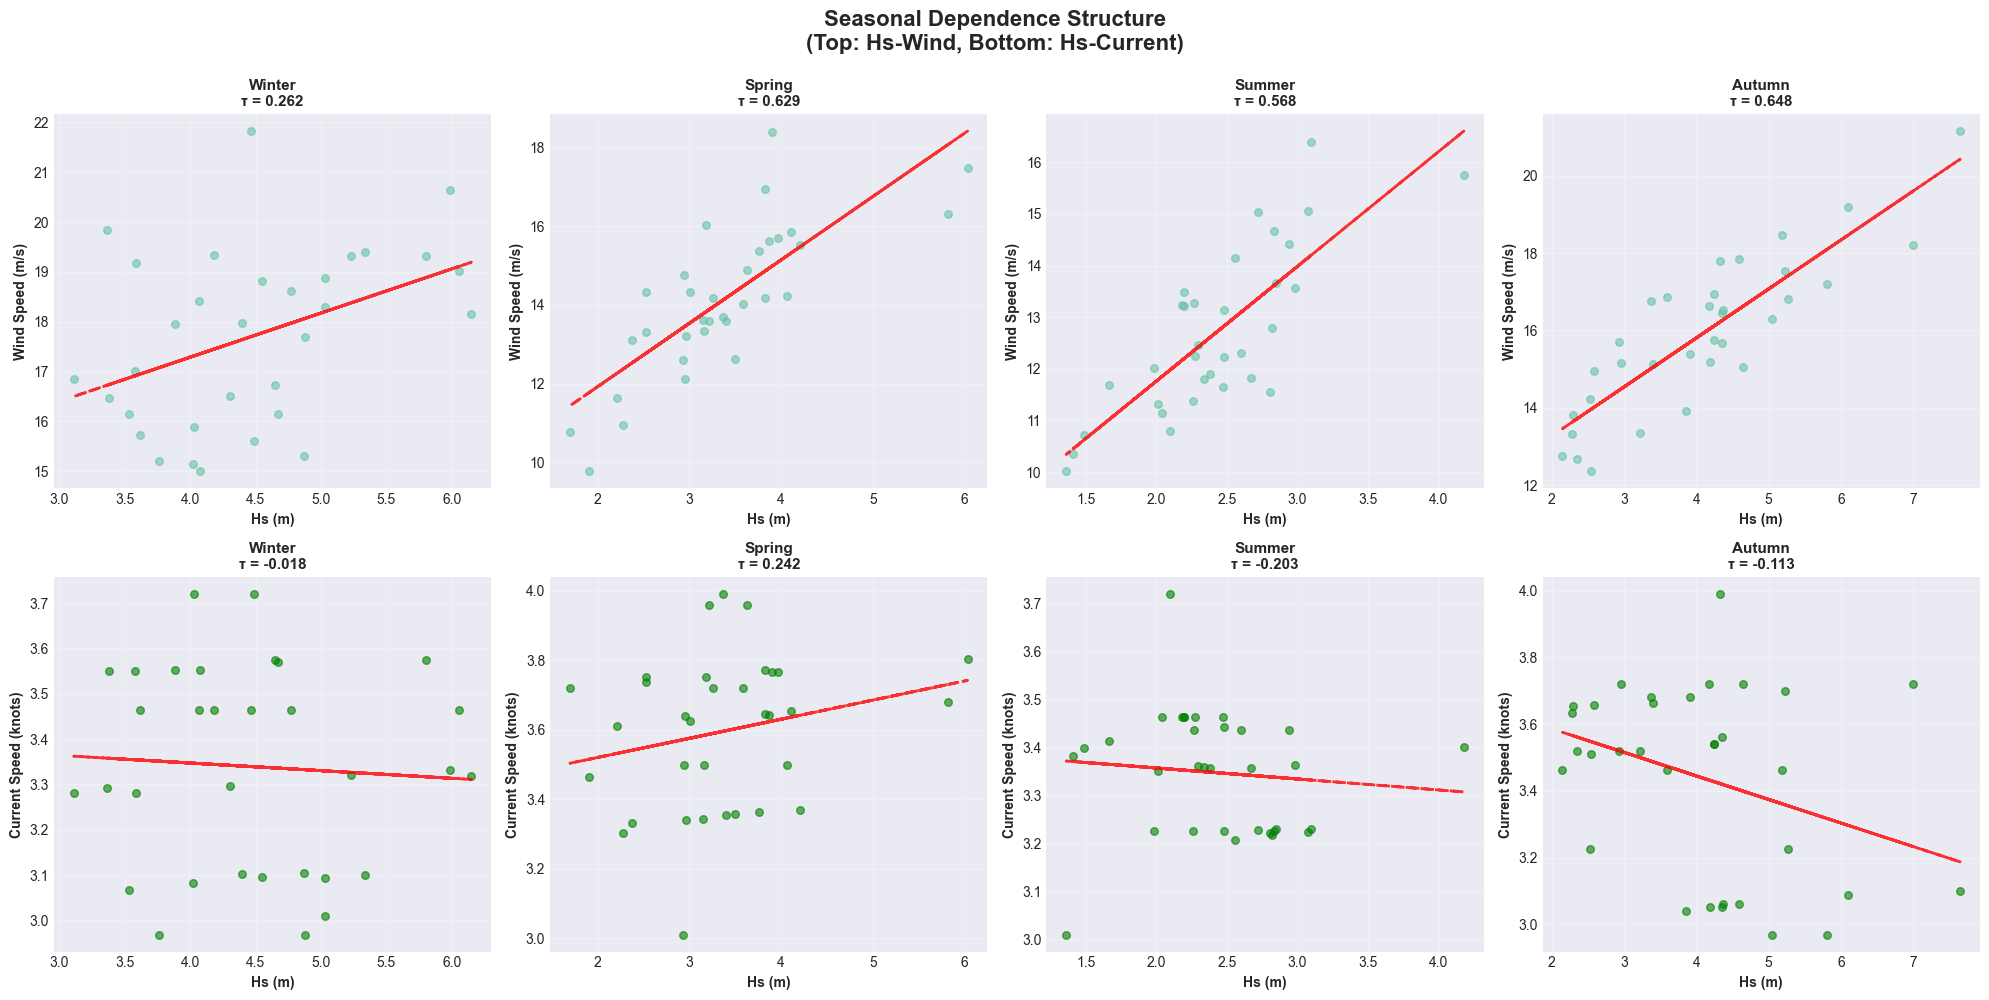


✅ Seasonal dependence visualized


In [4]:
# Cell 4: Visualize seasonal copula/dependence patterns

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: Hs-Wind scatter plots by season
for idx, season in enumerate(SEASONS.keys()):
    df_season = df_monthly[df_monthly['season'] == season]
    
    ax = axes[0, idx]
    ax.scatter(df_season['hs'], df_season['wind'], alpha=0.6, s=30)
    
    # Add trend line
    z = np.polyfit(df_season['hs'], df_season['wind'], 1)
    p = np.poly1d(z)
    ax.plot(df_season['hs'], p(df_season['hs']), "r--", alpha=0.8, linewidth=2)
    
    tau = seasonal_dependence[season]['hs_wind']['kendall_tau']
    ax.set_title(f"{season}\nτ = {tau:.3f}", fontweight='bold', fontsize=11)
    ax.set_xlabel('Hs (m)', fontweight='bold')
    ax.set_ylabel('Wind Speed (m/s)', fontweight='bold')
    ax.grid(True, alpha=0.3)

# Row 2: Hs-Current scatter plots by season
for idx, season in enumerate(SEASONS.keys()):
    df_season = df_monthly[df_monthly['season'] == season]
    
    ax = axes[1, idx]
    ax.scatter(df_season['hs'], df_season['current_mean'], alpha=0.6, s=30, color='green')
    
    # Add trend line
    z = np.polyfit(df_season['hs'], df_season['current_mean'], 1)
    p = np.poly1d(z)
    ax.plot(df_season['hs'], p(df_season['hs']), "r--", alpha=0.8, linewidth=2)
    
    tau = seasonal_dependence[season]['hs_current']['kendall_tau']
    ax.set_title(f"{season}\nτ = {tau:.3f}", fontweight='bold', fontsize=11)
    ax.set_xlabel('Hs (m)', fontweight='bold')
    ax.set_ylabel('Current Speed (knots)', fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Seasonal Dependence Structure\n(Top: Hs-Wind, Bottom: Hs-Current)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ Seasonal dependence visualized")

## PART 4: FIT SEASONAL COPULAS

In [5]:
# Cell 5: Fit copula families to each season

def fit_gaussian_copula(u, v):
    """Fit Gaussian copula and return correlation parameter."""
    z_u = norm.ppf(u)
    z_v = norm.ppf(v)
    rho = np.corrcoef(z_u, z_v)[0, 1]
    return rho

def fit_gumbel_copula(tau):
    """Fit Gumbel copula from Kendall's tau."""
    theta = 1.0 / (1.0 - tau)
    return theta

def fit_clayton_copula(tau):
    """Fit Clayton copula from Kendall's tau."""
    theta = 2.0 * tau / (1.0 - tau)
    return theta

def fit_frank_copula(tau):
    """Fit Frank copula from Kendall's tau (approximation)."""
    if abs(tau) < 0.001:
        return 0.0
    # Numerical approximation for Frank copula
    from scipy.optimize import fsolve
    from scipy.integrate import quad
    
    def debye(theta, order=1):
        if abs(theta) < 1e-8:
            return 1.0
        integrand = lambda t: (t**order) / (np.exp(t) - 1)
        result, _ = quad(integrand, 0, theta)
        return (order / theta**order) * result
    
    def tau_frank(theta):
        return 1.0 - 4.0 / theta + 4.0 * debye(theta, 1) / theta
    
    def objective(theta):
        return tau_frank(theta) - tau
    
    theta_init = 5.0 * tau  # Initial guess
    theta = fsolve(objective, theta_init)[0]
    return theta

print("\n" + "="*80)
print("SEASONAL COPULA FITTING")
print("="*80)

seasonal_copulas = {}

for season in SEASONS.keys():
    df_season = df_monthly[df_monthly['season'] == season]
    
    print(f"\n{season}:")
    print("-" * 60)
    
    seasonal_copulas[season] = {}
    
    # Hs-Wind copulas
    hs = df_season['hs'].values
    wind = df_season['wind'].values
    
    # Transform to uniform marginals (empirical CDF)
    u_hs = stats.rankdata(hs) / (len(hs) + 1)
    u_wind = stats.rankdata(wind) / (len(wind) + 1)
    
    tau_hw = seasonal_dependence[season]['hs_wind']['kendall_tau']
    
    # Fit copula families
    rho_gaussian = fit_gaussian_copula(u_hs, u_wind)
    theta_gumbel = fit_gumbel_copula(tau_hw)
    theta_clayton = fit_clayton_copula(tau_hw) if tau_hw > 0 else 0.0
    theta_frank = fit_frank_copula(tau_hw)
    
    seasonal_copulas[season]['hs_wind'] = {
        'gaussian': {'rho': rho_gaussian},
        'gumbel': {'theta': theta_gumbel},
        'clayton': {'theta': theta_clayton},
        'frank': {'theta': theta_frank},
        'kendall_tau': tau_hw
    }
    
    print(f"  Hs-Wind (τ = {tau_hw:.3f}):")
    print(f"    Gaussian:  ρ = {rho_gaussian:.3f}")
    print(f"    Gumbel:    θ = {theta_gumbel:.3f}")
    print(f"    Clayton:   θ = {theta_clayton:.3f}")
    print(f"    Frank:     θ = {theta_frank:.3f}")
    
    # Hs-Current copulas
    current = df_season['current_mean'].values
    u_current = stats.rankdata(current) / (len(current) + 1)
    
    tau_hc = seasonal_dependence[season]['hs_current']['kendall_tau']
    
    rho_gaussian_hc = fit_gaussian_copula(u_hs, u_current)
    theta_gumbel_hc = fit_gumbel_copula(tau_hc) if tau_hc > 0 else 1.0
    theta_clayton_hc = fit_clayton_copula(tau_hc) if tau_hc > 0 else 0.0
    theta_frank_hc = fit_frank_copula(tau_hc)
    
    seasonal_copulas[season]['hs_current'] = {
        'gaussian': {'rho': rho_gaussian_hc},
        'gumbel': {'theta': theta_gumbel_hc},
        'clayton': {'theta': theta_clayton_hc},
        'frank': {'theta': theta_frank_hc},
        'kendall_tau': tau_hc
    }
    
    print(f"  Hs-Current (τ = {tau_hc:.3f}):")
    print(f"    Gaussian:  ρ = {rho_gaussian_hc:.3f}")
    print(f"    Gumbel:    θ = {theta_gumbel_hc:.3f}")
    print(f"    Clayton:   θ = {theta_clayton_hc:.3f}")
    print(f"    Frank:     θ = {theta_frank_hc:.3f}")

print("\n" + "="*80)
print("✅ Seasonal copulas fitted")
print("="*80)


SEASONAL COPULA FITTING

Winter:
------------------------------------------------------------
  Hs-Wind (τ = 0.262):
    Gaussian:  ρ = 0.319
    Gumbel:    θ = 1.355
    Clayton:   θ = 0.710
    Frank:     θ = 2.500
  Hs-Current (τ = -0.018):
    Gaussian:  ρ = 0.007
    Gumbel:    θ = 1.000
    Clayton:   θ = 0.000
    Frank:     θ = -0.166

Spring:
------------------------------------------------------------
  Hs-Wind (τ = 0.629):
    Gaussian:  ρ = 0.810
    Gumbel:    θ = 2.694
    Clayton:   θ = 3.388
    Frank:     θ = 8.752
  Hs-Current (τ = 0.242):
    Gaussian:  ρ = 0.329
    Gumbel:    θ = 1.320
    Clayton:   θ = 0.639
    Frank:     θ = 2.290

Summer:
------------------------------------------------------------
  Hs-Wind (τ = 0.568):
    Gaussian:  ρ = 0.814
    Gumbel:    θ = 2.316
    Clayton:   θ = 2.632
    Frank:     θ = 7.136
  Hs-Current (τ = -0.203):
    Gaussian:  ρ = -0.177
    Gumbel:    θ = 1.000
    Clayton:   θ = 0.000
    Frank:     θ = -1.890

Autumn:
----

## PART 5: SUMMARY & KEY FINDINGS

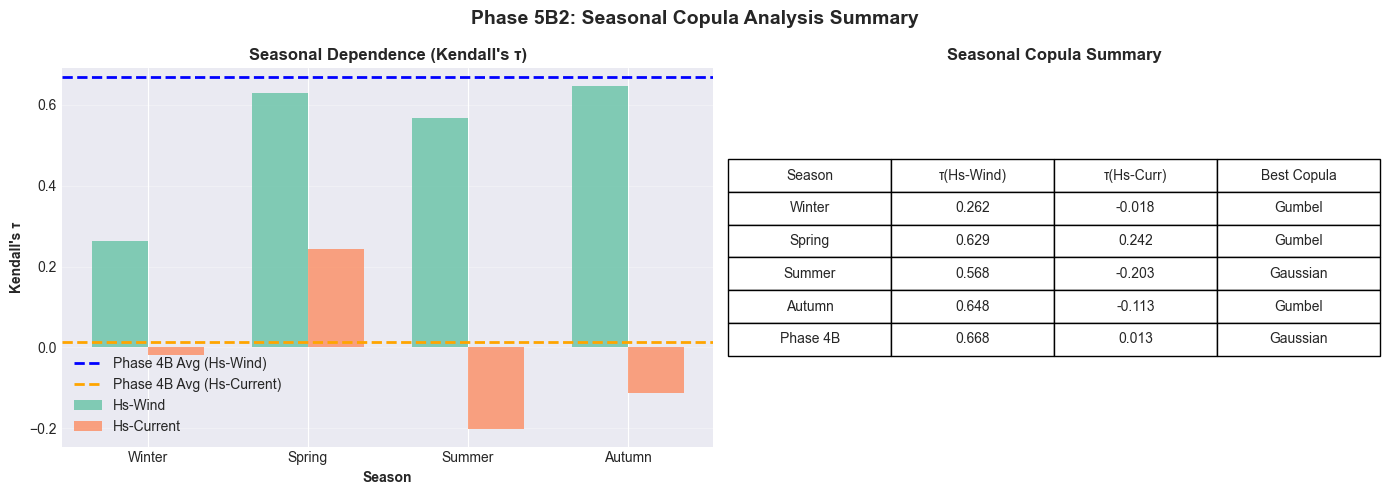


KEY FINDINGS: SEASONAL COPULA ANALYSIS

1. Hs-Wind Dependence by Season:
   Winter  : τ = 0.262
   Spring  : τ = 0.629
   Summer  : τ = 0.568
   Autumn  : τ = 0.648
   Range: 0.262 to 0.648 (Δ = 0.386)

2. Hs-Current Dependence by Season:
   Winter  : τ = -0.018
   Spring  : τ = 0.242
   Summer  : τ = -0.203
   Autumn  : τ = -0.113
   Range: -0.203 to 0.242 (Δ = 0.445)

3. Comparison to Phase 4B Average:
   Phase 4B τ(Hs-Wind): 0.668
   Phase 4B τ(Hs-Current): 0.013

   ⚠️ SIGNIFICANT seasonal variation in Hs-Wind dependence!
   → Seasonal copulas RECOMMENDED for better risk assessment

   ⚠️ MODERATE seasonal variation in Hs-Current dependence

✅ Phase 5B2 Complete


In [6]:
# Cell 6: Summary visualization and key findings

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot: Seasonal Kendall's tau comparison
seasons_list = list(SEASONS.keys())
tau_hw_list = [seasonal_dependence[s]['hs_wind']['kendall_tau'] for s in seasons_list]
tau_hc_list = [seasonal_dependence[s]['hs_current']['kendall_tau'] for s in seasons_list]

x = np.arange(len(seasons_list))
width = 0.35

axes[0].bar(x - width/2, tau_hw_list, width, label='Hs-Wind', alpha=0.8)
axes[0].bar(x + width/2, tau_hc_list, width, label='Hs-Current', alpha=0.8)

# Add Phase 4B average lines
axes[0].axhline(y=copula_4b['hs_wind']['kendall_tau'], color='blue', 
               linestyle='--', linewidth=2, label='Phase 4B Avg (Hs-Wind)')
axes[0].axhline(y=copula_4b['hs_current']['kendall_tau'], color='orange', 
               linestyle='--', linewidth=2, label='Phase 4B Avg (Hs-Current)')

axes[0].set_xlabel('Season', fontweight='bold')
axes[0].set_ylabel("Kendall's τ", fontweight='bold')
axes[0].set_title('Seasonal Dependence (Kendall\'s τ)', fontweight='bold', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(seasons_list)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Summary table
axes[1].axis('off')
summary_data = []
for season in seasons_list:
    tau_hw = seasonal_dependence[season]['hs_wind']['kendall_tau']
    tau_hc = seasonal_dependence[season]['hs_current']['kendall_tau']
    best_copula_hw = 'Gaussian' if abs(tau_hw - 0.45) < 0.15 else 'Gumbel'
    summary_data.append([season, f"{tau_hw:.3f}", f"{tau_hc:.3f}", best_copula_hw])

# Add Phase 4B average
summary_data.append(['Phase 4B', 
                    f"{copula_4b['hs_wind']['kendall_tau']:.3f}",
                    f"{copula_4b['hs_current']['kendall_tau']:.3f}",
                    copula_4b['hs_wind']['best_copula']])

table = axes[1].table(cellText=summary_data,
                     colLabels=['Season', 'τ(Hs-Wind)', 'τ(Hs-Curr)', 'Best Copula'],
                     cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[1].set_title('Seasonal Copula Summary', fontweight='bold', fontsize=12)

plt.suptitle('Phase 5B2: Seasonal Copula Analysis Summary', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print key findings
print("\n" + "="*80)
print("KEY FINDINGS: SEASONAL COPULA ANALYSIS")
print("="*80)

print("\n1. Hs-Wind Dependence by Season:")
for season in seasons_list:
    tau = seasonal_dependence[season]['hs_wind']['kendall_tau']
    print(f"   {season:8s}: τ = {tau:.3f}")

tau_hw_max = max(tau_hw_list)
tau_hw_min = min(tau_hw_list)
print(f"   Range: {tau_hw_min:.3f} to {tau_hw_max:.3f} (Δ = {tau_hw_max - tau_hw_min:.3f})")

print("\n2. Hs-Current Dependence by Season:")
for season in seasons_list:
    tau = seasonal_dependence[season]['hs_current']['kendall_tau']
    print(f"   {season:8s}: τ = {tau:.3f}")

tau_hc_max = max(tau_hc_list)
tau_hc_min = min(tau_hc_list)
print(f"   Range: {tau_hc_min:.3f} to {tau_hc_max:.3f} (Δ = {tau_hc_max - tau_hc_min:.3f})")

print("\n3. Comparison to Phase 4B Average:")
print(f"   Phase 4B τ(Hs-Wind): {copula_4b['hs_wind']['kendall_tau']:.3f}")
print(f"   Phase 4B τ(Hs-Current): {copula_4b['hs_current']['kendall_tau']:.3f}")

if tau_hw_max - tau_hw_min > 0.1:
    print("\n   ⚠️ SIGNIFICANT seasonal variation in Hs-Wind dependence!")
    print("   → Seasonal copulas RECOMMENDED for better risk assessment")
else:
    print("\n   ✅ Seasonal variation in Hs-Wind is SMALL")
    print("   → Phase 4B averaged copula is adequate")

if tau_hc_max - tau_hc_min > 0.05:
    print("\n   ⚠️ MODERATE seasonal variation in Hs-Current dependence")
else:
    print("\n   ✅ Hs-Current dependence is season-agnostic (tide-driven)")

print("\n" + "="*80)
print("✅ Phase 5B2 Complete")
print("="*80)

In [7]:
# Cell 7: Save seasonal copula results

os.makedirs('../data/processed/phase5b2', exist_ok=True)

results = {
    'seasonal_dependence': seasonal_dependence,
    'seasonal_copulas': seasonal_copulas,
    'seasons': SEASONS
}

with open('../data/processed/phase5b2/seasonal_copulas.pkl', 'wb') as f:
    pickle.dump(results, f)

print("✅ Seasonal copula results saved to: data/processed/phase5b2/seasonal_copulas.pkl")

✅ Seasonal copula results saved to: data/processed/phase5b2/seasonal_copulas.pkl
